# Chronological Attribution of ancient texts using deep NNs

In [20]:
import pandas as pd
import numpy as np

import data_explore

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from genfunctions import create_regression_mlp
from genfunctions import ngram_vectorize
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

In [21]:
# Start time of Execution
time_start = time()

In [22]:
data = pd.read_csv('iphi2802.csv', sep= '\t')
df = pd.DataFrame(data)

### Exploratory Data Analysis

In [23]:
df.head()

,id,text,metadata,region_main_id,region_main,region_sub_id,region_sub,date_str,date_min,date_max,date_circa
0,315181,[φ]ιλεταιρος ευμενου περγαμευς μουσαις. καφισι...,Boiotia — Thespiai — mid-3rd c. BC — BCH 26 (1...,1698,Central Greece (IG VII-IX),1691,"Megaris, Oropia, and Boiotia (IG VII)",mid-3rd c. BC,-275.0,-226.0,0.0
1,201686,μαλκοιδων ηρωνος.,"Crete, W. — Tarrha — 1st-3rd c. AD — IC II xxi...",1699,"Aegean Islands, incl. Crete (IG XI-[XIII])",474,Crete,1st-3rd c. AD,1.0,300.0,0.0
2,153178,βασιλικος.,Makedonia (Bottiaia) — Pella — 3rd/2nd c. BC —...,1692,Northern Greece (IG X),1485,Macedonia,3rd/2nd c. BC,-300.0,-101.0,0.0
3,28582,αισκλαπιει μ [ανεθεκε --].,Epidauria — Epidauros — sinistr. — 6th/5th c. BC,1690,Peloponnesos (IG IV-[VI]),1643,"Epidauria (IG IV²,1)",6th/5th c. BC,-600.0,-401.0,0.0
4,333620,[---]ος αν[εθηκε δαματρι].,Italia — Herakleia (Policoro) — late 4th/early...,1696,"Sicily, Italy, and the West (IG XIV)",1689,"Italy, incl. Magna Graecia",late 4th/early 3rd c. BC,-350.0,-251.0,0.0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2802 entries, 0 to 2801
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2802 non-null   int64  
 1   text            2802 non-null   object 
 2   metadata        2802 non-null   object 
 3   region_main_id  2802 non-null   int64  
 4   region_main     2802 non-null   object 
 5   region_sub_id   2802 non-null   int64  
 6   region_sub      2802 non-null   object 
 7   date_str        2802 non-null   object 
 8   date_min        2802 non-null   float64
 9   date_max        2802 non-null   float64
 10  date_circa      2802 non-null   float64
dtypes: float64(3), int64(3), object(5)
memory usage: 240.9+ KB


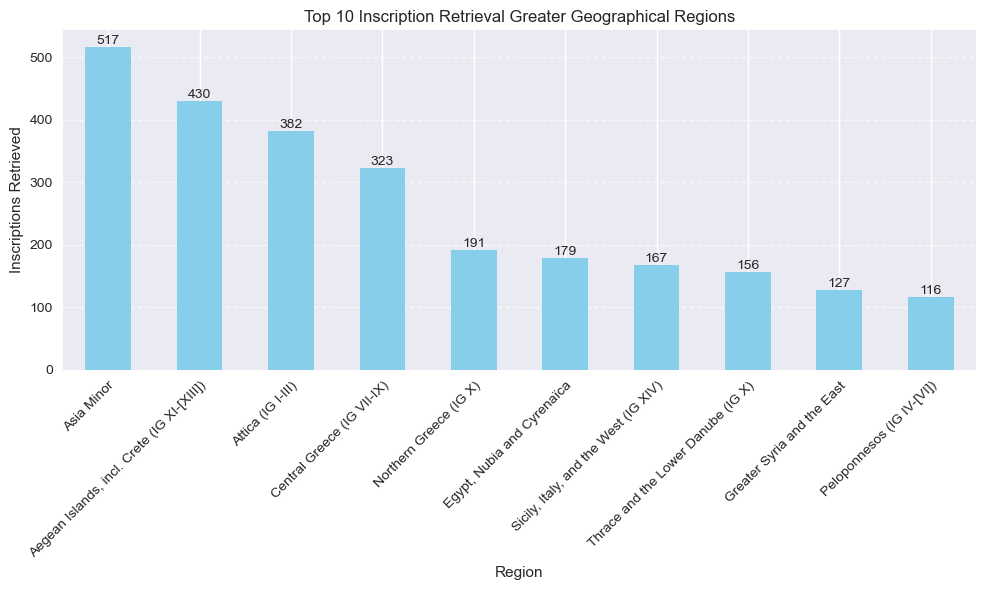

In [25]:
region_main_dict = {key: value for key, value in zip(df['region_main_id'], df['region_main'])}
region_sub_dict = {key: value for key, value in zip(df['region_sub_id'], df['region_sub'])}
region_dict = {
    'region_main_dict': region_main_dict,
    'region_sub_dict': region_sub_dict
}
# Plot the histogram
plt.figure(figsize=(10, 6))
bars = df['region_main_id'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Inscription Retrieval Greater Geographical Regions')
plt.xlabel('Region')
plt.ylabel('Inscriptions Retrieved')
plt.xticks(range(len(df['region_main_id'].value_counts().head(10))), [region_main_dict[key] for key in df['region_main_id'].value_counts().head(10).index], rotation=45, ha='right', rotation_mode='anchor')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), ha='center', va='bottom')

plt.tight_layout()

plt.show()

### Data Preprocessing

In [26]:
text = df['text']

df = df.assign(date_mean=(df['date_min'] + df['date_max']) / 2)

labels = df['date_mean']


(7.0, 81315)


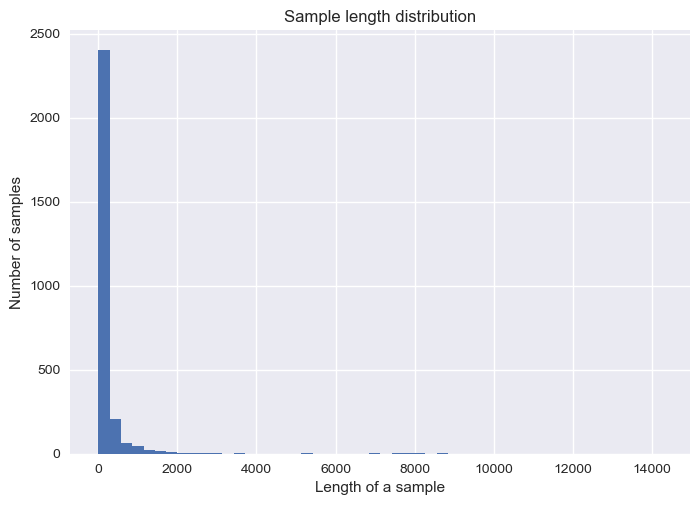

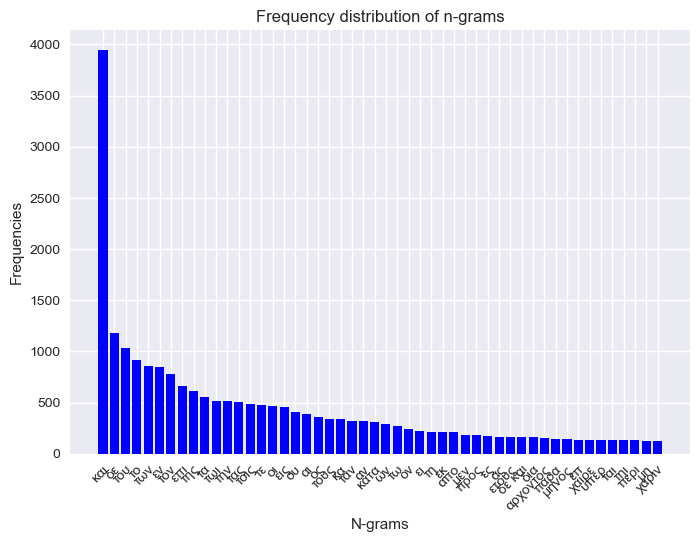

In [27]:
print(data_explore.get_num_words_per_sample(text))
ave, ngrams = data_explore.get_num_words_per_sample(text)
data_explore.plot_sample_length_distribution(text)
data_explore.plot_frequency_distribution_of_ngrams(text)

In [28]:
print(f'#Samples / average_number_of_words_per_sample = {2802/ave:.2f}')

#Samples / average_number_of_words_per_sample = 400.29


In [29]:
# Split data
text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=.3, random_state=42) 

In [30]:
T_train, T_test = ngram_vectorize(text_train, labels_train, text_test)

/Users/ioannisvelgakis/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:2065: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


In [31]:
print(f'Train Set size: {T_train.shape}, Test Set size: {T_test.shape}')

Train Set size: (1961, 623), Test Set size: (841, 623)


In [32]:
scaler = StandardScaler(with_mean=False)

# Fit the scaler to your data (computes mean and standard deviation)
scaler.fit(T_train)

# Transform your data using the scaler (standardizes the data)
T_train_scaled = scaler.transform(T_train)
T_test_scaled = scaler.transform(T_test)

In [33]:
T_train_scaled.shape

(1961, 623)

In [34]:
train_data = (T_train_scaled, labels_train)  # Tuple of training texts and labels
test_data = (T_test_scaled, labels_test)  # Tuple of validation texts and labels


model = create_regression_mlp(
    input_shape=T_train_scaled.shape[1:],
    x_train=T_train_scaled,
    train_labels=labels_train,
    epochs=100,
    validation_data=test_data,  # Providing test_data as validation data
    batch_size=32)

Epoch 1/100


/Users/ioannisvelgakis/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 - 0s - 5ms/step - loss: 74851.0625 - val_loss: 82482.0234
Epoch 2/100
62/62 - 0s - 871us/step - loss: 74165.1875 - val_loss: 81654.3672
Epoch 3/100
62/62 - 0s - 835us/step - loss: 72968.4062 - val_loss: 80352.4297
Epoch 4/100
62/62 - 0s - 866us/step - loss: 71313.5312 - val_loss: 78766.8281
Epoch 5/100
62/62 - 0s - 809us/step - loss: 69400.9531 - val_loss: 77061.2734
Epoch 6/100
62/62 - 0s - 834us/step - loss: 67397.1172 - val_loss: 75439.5547
Epoch 7/100
62/62 - 0s - 888us/step - loss: 65454.4648 - val_loss: 73959.3125
Epoch 8/100
62/62 - 0s - 839us/step - loss: 63645.4062 - val_loss: 72633.3594
Epoch 9/100
62/62 - 0s - 828us/step - loss: 61986.1992 - val_loss: 71462.6875
Epoch 10/100
62/62 - 0s - 825us/step - loss: 60423.1016 - val_loss: 70439.5156
Epoch 11/100
62/62 - 0s - 795us/step - loss: 59003.2852 - val_loss: 69550.8828
Epoch 12/100
62/62 - 0s - 812us/step - loss: 57648.0820 - val_loss: 68727.8281
Epoch 13/100
62/62 - 0s - 798us/step - loss: 56392.6641 - val_loss: 68044.0

In [35]:
print(f'Took {(time() - time_start) / 60:.2f} minutes!')

Took 0.15 minutes!
